<h1 style="color:#987753"><center>============= IMPORT DEPANDENCIES =============</center></h1>

In [29]:
# Démarrage de tensorboard pour notebook
%load_ext tensorboard

# Les imports majeurs, certains ne sont peut être plus utiles -> à re-vérifier 
import sys
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import os
import pandas as pd
import random
#from PIL import Image
import shutil  
from tensorflow.keras.callbacks import TensorBoard


import time

from datetime import date

from tensorflow.python.framework import ops #pour tenter de reset tensorboard, sans grand succès
ops.reset_default_graph()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<h1 style="color:#987753"><center>============= UTILS FUNCTION =============</center></h1>

In [2]:
global ID
ID = random.randint(1,1000000)

In [3]:
def getTime():
    
    now = datetime.now()
    current_time = now.strftime("%H-%M-%S")
    today = str(date.today()).split('-')
    today = today[2]+"_"+today[1]+"_"+today[0]
    runTime = ("%s_%s" %(today,current_time))
    return runTime


In [4]:
def logName():
    
    NAME = "ModelCifar10_RNN_"+str(ID)+"_"+getTime()
    return NAME

{"neurons":248, "activation":"sigmoid","dropOut":False},
{"neurons":145, "activation":"sigmoid", "dropOut":False},
{"neurons":10, "activation":"softmax", "dropOut":False}

In [94]:
def hyperParams():

    Params = {"neurons":128,
                   "activation":"tanh", 
                   "dropOut":False,
                   "loss":"mean_squared_error",
                   "optimizer":"Adam",
                   "metrics":"accuracy",
                   "epochs":20,
                   "batchSize":50
                 }
    return Params

params = hyperParams()


In [6]:
def humainesLabels(position):
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    return labels[position]

In [7]:
def humanizeTime(secs):
    mins, secs = divmod(secs, 60)
    hours, mins = divmod(mins, 60)
    return ('RUN TIME : %02d:%02d:%02d' % (hours, mins, secs))

In [13]:
def load_dataset():
    # Chargement des données cifar10
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    # one hot encode encoding sur les labels
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)  
    
    Xtrain = np.reshape(np.asarray([np.mean(im, axis=2, keepdims=True) for im in trainX]),(50000,32,32))
    Xtest = np.reshape(np.asarray([np.mean(im, axis=2, keepdims=True) for im in testX]),(10000,32,32))
        
    
    return Xtrain, trainY, Xtest, testY

x_train, y_train, x_test, y_test=load_dataset()

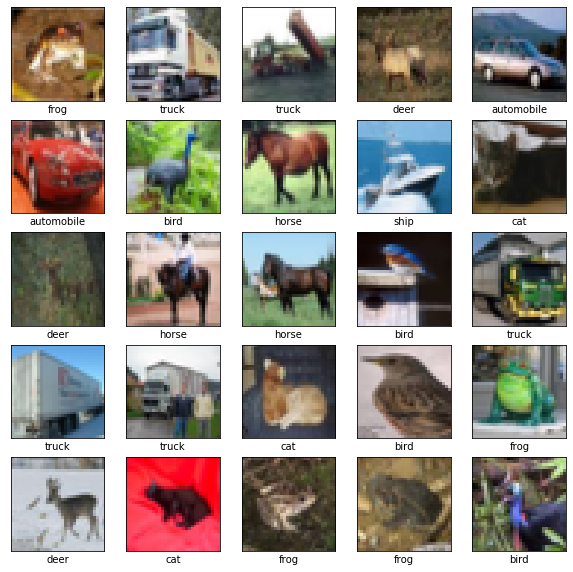

In [9]:
def plotFigure(images=False, labels=False, nbSamples=0, size=10):
    
    plt.figure(figsize=(size, size))
    for i in range(nbSamples):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
       
        plt.xlabel(humainesLabels(labels[i][0]))
    plt.show()
    
plotFigure(trainImages, trainLabels, nbSamples=25)

<h1 style="color:#987753"><center>============= INIT MODEL =============</center></h1>

In [10]:
def oneHoteEncoding(trainLabels, testLabels):
    
    trainLabels = tf.keras.utils.to_categorical(trainLabels)
    testLabels = tf.keras.utils.to_categorical(testLabels)
    
    return trainLabels, testLabels

trainLabels, testLabels = oneHoteEncoding(trainLabels, testLabels)

In [88]:
def createModel(params):
    
    model = Sequential()

    

    model.add(LSTM(params['neurons'],activation=params['activation'], input_shape=(32, 32)))
    model.add(Dense(10,activation="softmax"))
    if (params['dropOut'] != False):
        model.add(Dropout(params['dropOut']))
    model.compile(loss=params['loss'],
                   optimizer=params['optimizer'],
                   metrics=[params['metrics']])
    
    

    model.summary()
    return model

model = createModel(params)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 512)               1116160   
_________________________________________________________________
dense_10 (Dense)             (None, 10)                5130      
Total params: 1,121,290
Trainable params: 1,121,290
Non-trainable params: 0
_________________________________________________________________


<h1 style="color:#987753"><center>============= TRAIN MODEL =============</center></h1>

In [12]:
def reshapeInput(trainImages, testImages):
    
    trainImages.reshape(trainImages.shape[0], trainImages.shape[1] * trainImages.shape[2] * trainImages.shape[3]) #
    testImages.reshape(testImages.shape[0], testImages.shape[1] * testImages.shape[2] * testImages.shape[3]) #
    
    return trainImages, testImages

trainImages, testImages = reshapeInput(trainImages, testImages)

In [17]:
params

{'neurons': 10,
 'activation': 'relu',
 'dropOut': False,
 'loss': 'mean_squared_error',
 'optimizer': 'Adam',
 'metrics': 'accuracy',
 'epochs': 2,
 'batchSize': 5}

In [57]:
def fitModel(model, params):
    
    start_time = time.time()
    tensorboard = TensorBoard(log_dir='C:\logsProject\{}'.format(logName()))
    ################################ CALCULATE RUNTIME - START ###############################
    model.fit(x_train, y_train,
                       epochs=params['epochs'],
                       batch_size=params['batchSize'],
                       validation_data=(x_test, y_test), verbose=1, callbacks=[tensorboard])
    ################################ CALCULATE RUNTIME - END ###############################
    print(humanizeTime(time.time() - start_time))
    return model, humanizeTime(time.time() - start_time)

model, runTime = fitModel(model, params)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 59s 1ms/sample - loss: 0.0955 - accuracy: 0.1086 - val_loss: 0.0905 - val_accuracy: 0.1061
Epoch 2/20
50000/50000 [==============================] - 48s 969us/sample - loss: 0.0903 - accuracy: 0.1127 - val_loss: 0.0900 - val_accuracy: 0.1209
Epoch 3/20
50000/50000 [==============================] - 48s 967us/sample - loss: 0.0901 - accuracy: 0.1144 - val_loss: 0.0899 - val_accuracy: 0.1147
Epoch 4/20
50000/50000 [==============================] - 48s 966us/sample - loss: 0.0896 - accuracy: 0.1421 - val_loss: 0.0895 - val_accuracy: 0.1499
Epoch 5/20
50000/50000 [==============================] - 48s 968us/sample - loss: 0.0893 - accuracy: 0.1494 - val_loss: 0.0893 - val_accuracy: 0.1455
Epoch 6/20
50000/50000 [==============================] - 48s 969us/sample - loss: 0.0890 - accuracy: 0.1557 - val_loss: 0.0891 - val_accuracy: 0.1452
Epoch 7/20
50000/50000 [======================

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 292s 6ms/sample - loss: 2.2285 - accuracy: 0.1630 - val_loss: 2.2006 - val_accuracy: 0.1861
Epoch 2/20
50000/50000 [==============================] - 288s 6ms/sample - loss: 2.1803 - accuracy: 0.1825 - val_loss: 2.1742 - val_accuracy: 0.1870
Epoch 3/20
50000/50000 [==============================] - 289s 6ms/sample - loss: 2.1682 - accuracy: 0.1885 - val_loss: 2.1624 - val_accuracy: 0.1927
Epoch 4/20
50000/50000 [==============================] - 290s 6ms/sample - loss: 2.1724 - accuracy: 0.1915 - val_loss: 2.1669 - val_accuracy: 0.1935
Epoch 5/20
50000/50000 [==============================] - 288s 6ms/sample - loss: 2.1602 - accuracy: 0.1972 - val_loss: 2.1505 - val_accuracy: 0.1997
Epoch 6/20
50000/50000 [==============================] - 288s 6ms/sample - loss: 2.1497 - accuracy: 0.1979 - val_loss: 2.1431 - val_accuracy: 0.2065
Epoch 7/20
50000/50000 [==========================

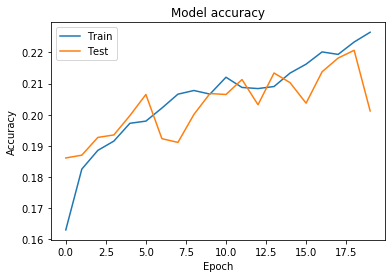

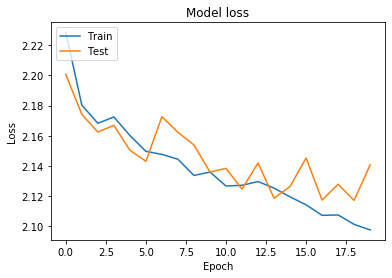

In [95]:
import matplotlib.pyplot as plt
start_time = time.time()
    
history = model.fit(x_train, y_train, epochs=params['epochs'], validation_data=(x_test, y_test), batch_size=params['batchSize'])

print(humanizeTime(time.time() - start_time))


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<h1 style="color:#987753"><center>============= EVALUATE MODEL =============</center></h1>

In [96]:
def evaluateModel(model):
    
    return model.evaluate(x_test, y_test, batch_size=50)

resultEV = evaluateModel(model)
resultEV

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[2.140772806406021, 0.2012]

<h1 style="color:#987753"><center>============= PREDICT =============</center></h1>

In [97]:
def predictionPercent(model, x_test, y_test):
    
    prediction = model.predict(x_test)
    predicted = []
    for i in range(len(prediction)):
        if np.argmax(y_test[i]) == np.argmax(prediction[i]):
            predicted.append(1)
        else:
            predicted.append(0)
    print("Predicted precent {} %".format((sum(predicted)/(len(predicted)) * 100)))
    result = (sum(predicted)/len(predicted)) * 100
    
    return prediction, result

prediction, result = predictionPercent(model, x_test, y_test)

Predicted precent 20.119999999999997 %


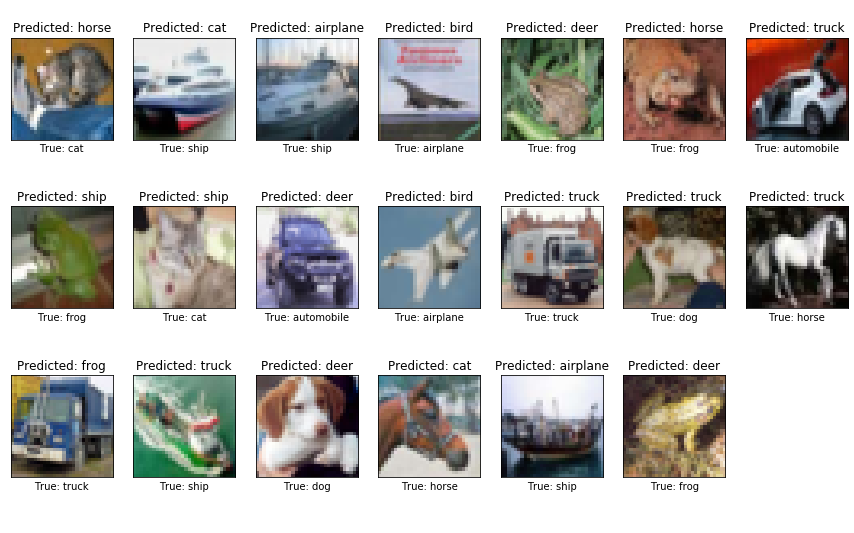

In [42]:
def plotPredictedResult(prediction, testImages, testLabels):
    
    plt.figure(figsize=(15, 15))
    for i in range(20):
        plt.subplot(5,7,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(testImages[i])
        plt.xlabel("True: "+humainesLabels(np.argmax(testLabels[i]))+"\n\n\n")
        plt.title("\nPredicted: "+humainesLabels(np.argmax(prediction[i])))
    plt.show()
    
plotPredictedResult(prediction, testImages, testLabels)